In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import itertools
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
np.set_printoptions(threshold=np.nan)
from sklearn import preprocessing

In [19]:
data = pd.read_csv("../Data/preprocessed_alcoholdata_full.csv") 

data = data.drop(['Unnamed: 0'], axis=1)
data['Conditie'] = data['Conditie'].map({'norm': 0,  'bril': 1})
data = data[data.Conditie != 1]
data['Alcohol'] = data['Alcohol'].map({'Sober': 0,  'Light': 1, 'Tipsy': 2, 'Drunk': 3})
data

,TestID,Conditie,SubjectID,SegmentNr,WalkingDirection,SegmentData,Alcohol,Height,Weight,Age,BMI,AverageStepLength,std_SegmentData,SumDistance
0,006A01',0,6,1,away,[[array([[0.04697253]]) array([[-0.18321628]])...,0,177,70.0,20,22.343516,0.610128,0.060870,31.536056
1,006A01',0,6,2,towards,[[array([[0.40771624]]) array([[-0.22044282]])...,0,177,70.0,20,22.343516,0.681944,0.038465,11.903862
2,006A01',0,6,3,away,[[array([[0.09305737]]) array([[-0.19160482]])...,0,177,70.0,20,22.343516,0.713798,0.030903,19.427288
3,006A01',0,6,4,towards,[[array([[0.44424376]]) array([[-0.2283845]]) ...,0,177,70.0,20,22.343516,0.651639,0.074751,14.089522
4,009A01',0,9,1,away,[[array([[-0.08974021]]) array([[-0.0481508]])...,0,195,86.0,23,22.616700,0.768314,0.028861,27.897639
5,009A01',0,9,2,towards,[[array([[0.47497733]]) array([[-0.09702823]])...,0,195,86.0,23,22.616700,0.685495,0.029494,14.634647
6,009A01',0,9,3,away,[[array([[0.00489379]]) array([[-0.07232992]])...,0,195,86.0,23,22.616700,0.689099,0.017266,23.734207
7,009A01',0,9,4,towards,[[array([[0.51498991]]) array([[-0.09675995]])...,0,195,86.0,23,22.616700,0.660362,0.015360,12.242523
8,010A01',0,10,1,away,[[array([[-0.33516738]]) array([[-0.30029692]]...,0,165,65.0,28,23.875115,0.538055,0.068683,40.414894
9,010A01',0,10,2,towards,[[array([[0.54318447]]) array([[-0.34777679]])...,0,165,65.0,28,23.875115,0.571604,0.024063,21.754895


In [20]:
sidlist = data['SubjectID'].unique()

#Make an array out of all rows for every unique SubjectID and list them together
grouped_data = [data[data['SubjectID']==sid] for sid in sidlist]
# grouped_data[0]

In [21]:
#Splits data into training and validation according to specified ratio
def validation_split(data, ratio):
    np.random.shuffle(data)
    N = len(data)
    training = data[:int(ratio*N)]
    validation = data[(int(ratio*N)):]
    return training,validation

# Converts the arrays in a list to one flattend dataframe
def flatten(data):
    return pd.DataFrame(np.vstack(data), columns=['TestID', 'Conditie', 'SubjectID','SegmentNr','WalkingDirection',        
 'SegmentData', 'Alcohol', 'Height', 'Weight', 'Age', 'BMI', 'std_SegmentData', 'Som_afstand', 'AverageStepLength'])

training,validation = validation_split(grouped_data, 0.7)
training = flatten(training)
validation = flatten(validation)



In [22]:
training_matrix = training.as_matrix()
X_train = np.array(training_matrix[:,[13, 11]], dtype=float)
y_train = np.array(training_matrix[:, 6], dtype=int)
validation_matrix = validation.as_matrix()
X_test = np.array(validation_matrix[:,[13, 11]], dtype=float)
y_test = np.array(validation_matrix[:, 6], dtype=int)


Accuracy of our model is equal 67.55 %.


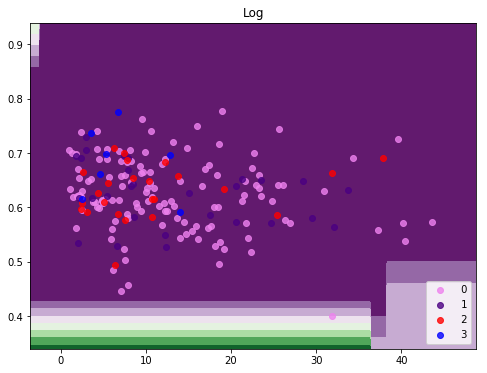

In [23]:
#Twee features

logreg = LogisticRegression(C=1e5, solver='lbfgs', multi_class='multinomial', random_state=100000, max_iter=1000)

logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)*100
print('Accuracy of our model is equal ' + str(round(accuracy, 2)) + ' %.')

#Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
padding = 0.1
resolution = 0.1

colors = {0: 'violet', 1: 'indigo', 2: 'red', 3: 'blue'}
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * padding
y_min -= y_range * padding
x_max += x_range * padding
y_max += y_range * padding

# Get decision boundaries from model
xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                     np.arange(y_min, y_max, resolution))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour map
plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn)
plt.axis('tight')

# Plot your testing points as wel
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

plt.legend(loc='lower right')
plt.title('Log')
plt.show()

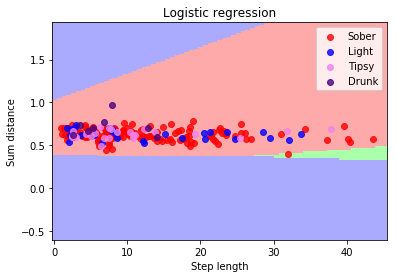

In [24]:
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

h = .02  # step size in the mesh
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])
colors = {0: 'red', 1: 'blue', 2: 'violet', 3: 'indigo'}
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Plot also the training points
# plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold)

score = logreg.score(X_test, y_test)
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, alpha=0.5, cmap=cmap_bold)

for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label=' {}'.format(label))

colors = ['red', 'blue', 'violet', 'indigo']

labels = ['Sober', 'Light', 'Tipsy', 'Drunk']
plt.legend(labels)
plt.title('Logistic regression')
plt.xlabel('Step length')
plt.ylabel('Sum distance')
plt.savefig('Logistic regression')
plt.show()